In [1]:
# to make fun gif at the end
from geogif import gif
# takes stac items and makes a raster
import odc.stac
# allows us to interact with MPC
import planetary_computer
# the stac api library
import pystac_client
# allows us to make the table of atrib
import rich.table

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
# 2021 Dixie Wildfire in California
latitude = 40.7310
longitude = -122.9420
location = [longitude, latitude]
geometry = {
    "type": "Point",
    "coordinates": location,
}
datetimes = [
    "2021-07-12",
    "2021-07-20",
    "2021-07-28",
    "2021-08-05",
    "2021-08-13",
    "2021-08-21",
]

buffer = 0.7
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
items = dict()

# Fetch the collection of interest and print availabe items
for datetime in datetimes:
    print(f"Fetching {datetime}")
    search = catalog.search(
        collections=["modis-14A2-061"],
        intersects=geometry,
        datetime=datetime,
    )
    items[datetime] = search.get_all_items()[0]

print(items)

Fetching 2021-07-12
Fetching 2021-07-20
Fetching 2021-07-28
Fetching 2021-08-05
Fetching 2021-08-13
Fetching 2021-08-21
{'2021-07-12': <Item id=MYD14A2.A2021193.h08v04.061.2021202231138>, '2021-07-20': <Item id=MYD14A2.A2021201.h08v04.061.2021210025058>, '2021-07-28': <Item id=MYD14A2.A2021209.h08v04.061.2021218015513>, '2021-08-05': <Item id=MYD14A2.A2021217.h08v04.061.2021226035858>, '2021-08-13': <Item id=MYD14A2.A2021225.h08v04.061.2021234033430>, '2021-08-21': <Item id=MYD14A2.A2021233.h08v04.061.2021243064108>}


In [5]:
t = rich.table.Table("Asset", "Description")
for key, asset in items["2021-07-12"].assets.items():
    t.add_row(key, asset.title)
t

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset            ┃ Description                                       ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ QA               │ Pixel quality indicators                          │
│ hdf              │ Source data containing all bands                  │
│ FireMask         │ Confidence of fire                                │
│ metadata         │ Federal Geographic Data Committee (FGDC) Metadata │
│ tilejson         │ TileJSON with default rendering                   │
│ rendered_preview │ Rendered preview                                  │
└──────────────────┴───────────────────────────────────────────────────┘

In [7]:
data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bbox=bbox,
    bands="FireMask",
    resolution=1000,
)
data = data.where(data < 10, drop=True)
data

<xarray.Dataset>
Dimensions:      (time: 6, y: 207, x: 157)
Coordinates:
  * y            (y) float64 5.076e+06 5.076e+06 ... 4.872e+06 4.87e+06
  * x            (x) float64 -1.376e+07 -1.376e+07 ... -1.361e+07 -1.361e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-07-12 2021-07-20 ... 2021-08-21
Data variables:
    FireMask     (time, y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0

/var/folders/sx/xqfwzbyj34987h8f6pslsmc80000gp/T/ipykernel_17987/4201021179.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, datetime in zip(g.axes.flat, datetimes):


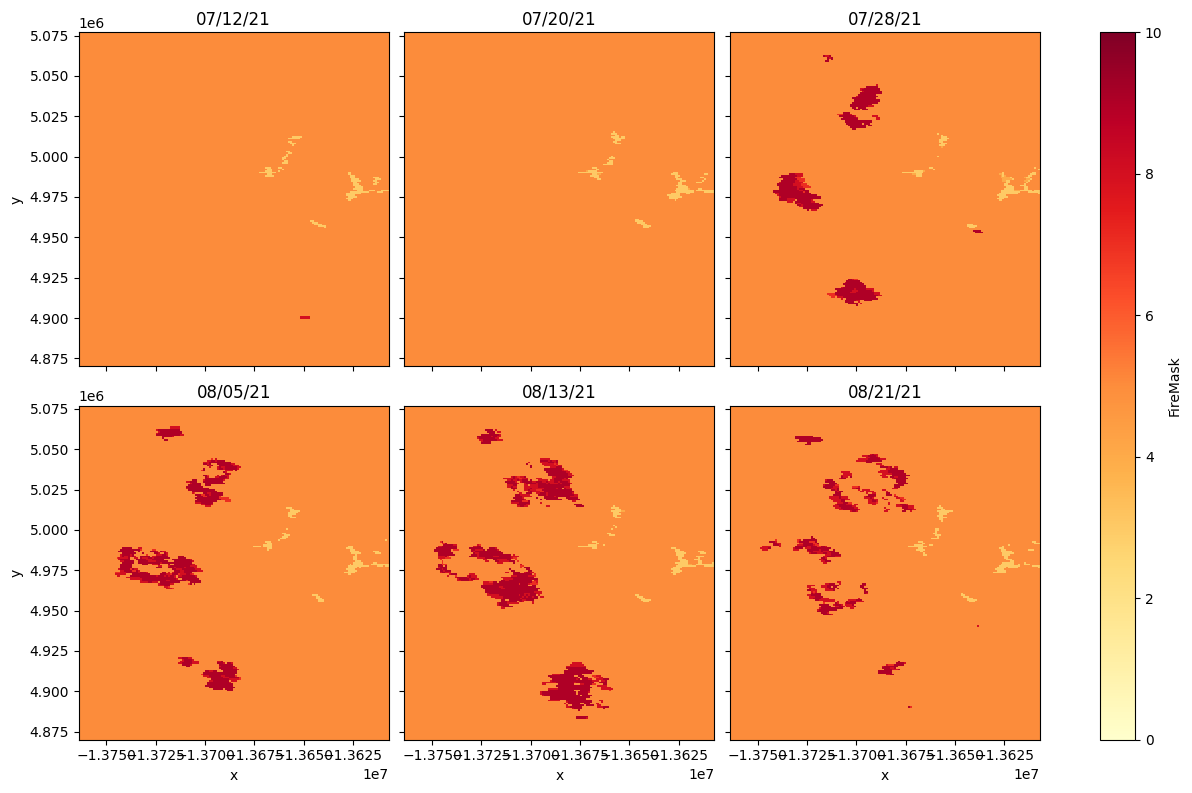

In [8]:
g = data["FireMask"].plot.imshow(
    cmap="YlOrRd", col="time", vmin=0, vmax=10, col_wrap=3, size=4
)
datetimes = data["FireMask"].time.to_pandas().dt.strftime("%D")

for ax, datetime in zip(g.axes.flat, datetimes):
    ax.set_title(datetime)

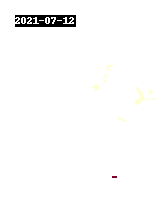

In [9]:
data = data.where(data < 9)
gif(data.FireMask, fps=3, cmap="YlOrRd")